# Проект исследования стартапов

Цель проекта:

- Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. 
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

План работ:

- загрузка и ознакомление с данными,
- предварительная обработка,
- исследовательский анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

Датасет состоит из двух файлов: тренировочный и тестовый.

Описание полей данных:

- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

<div style="background: #bbdb92">Зеленым фоном подсвечены выводы по разделам.</div>
<div style="background: #f5f7c4">Желтым фоном подсвечены промежуточные комментарии.</div>

## Установка и импорт необходимых библиотек и модулей

In [1]:
!pip install matplotlib -q
!pip install scikit-learn --upgrade -q
!pip install shap -q
!pip install phik -q

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score

import shap

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
#определяем константы

TEST_SIZE=0.25
RANDOM_STATE=42

## Загрузка и ознакомление с данными

In [66]:
train = pd.read_csv("/Users/ADMINX/Project startup/kaggle_startups_train_28062024.csv")

In [67]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [68]:
train.shape

(52516, 13)

In [69]:
test = pd.read_csv("/Users/ADMINX/Project startup/kaggle_startups_test_28062024.csv")

In [70]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [71]:
test.shape

(13125, 11)

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [73]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


<div style="background: #bbdb92"><b>Выводы по разделу "Загрузка и ознакомление с данными"</b>
<br><br><div style="background: #bbdb92">Файлы загружены, данные соответствуют описанию данных.
<br><br>Тренировочная выборка содержит 52.516 строк и 13 признаков. Целевой признак - status.
<br><br>Тестовая выборка содержит 13.125 строк и 11 признаков. Необходимо предсказать значение 'status' для каждого стартапа из этого датасета.
<br><br>Нужно преобразовать признаки с датами в тип datetime.</div>

## Предобработка данных

<div style="background: #f5f7c4">Заменим тип данных столбцов с датами на тип datetime и оставим лишь год. </div>

In [74]:
train['founded_at'] = pd.to_datetime(train['founded_at']).dt.year.astype(int)
train['first_funding_at'] = pd.to_datetime(train['first_funding_at']).dt.year.astype(int)
train['last_funding_at'] = pd.to_datetime(train['last_funding_at']).dt.year.astype(int)

test['first_funding_at'] = pd.to_datetime(test['first_funding_at']).dt.year.astype(int)
test['last_funding_at'] = pd.to_datetime(test['last_funding_at']).dt.year.astype(int)

In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  int32  
 10  first_funding_at   52516 non-null  int32  
 11  last_funding_at    52516 non-null  int32  
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int32(3), int64(1), object(8)
memory usage: 4.6+ MB


<div style="background: #f5f7c4">Проверим наличие пропусков в файлах.

In [20]:
train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [21]:
test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

<div style="background: #f5f7c4">Пропусков довольно много в обоих файлах. Проверим наличие явных дубликатов.</div>

In [22]:
train.duplicated().sum()

0

In [23]:
test.duplicated().sum()

0

<div style="background: #f5f7c4">Проверим наличие НЕявных дубликатов.</div>

In [24]:
#список категориальных признаков train

cat_col = ['category_list', 'country_code', 'state_code', 'region', 'city']

In [25]:
#вывод уникальных значений train

for i in cat_col:
    print(f'Уникальные значения {i}: {train[i].unique()}')
    print()

Уникальные значения category_list: ['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']

Уникальные значения country_code: ['CHE' 'USA' nan 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS' 'TWN'
 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD' 'ARG'
 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA' 'GRC'
 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA' 'JOR'
 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX' 'SVN'
 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA' 'TTO'
 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT' 'PSE'
 'BLZ' 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM' 'PRY' 'BMU'
 'TAN' 'LIE' 'GRD' 'UZB' 'GEO' 'SEN' 'ALB' 'ECU' 'MOZ' 'LKA' 'LAO' 'TUN'
 'HND' 'ZWE' 'BAH' 'MDA' 'MAF' 'BHR' 'AZE' 'MAR' 'KWT' '

In [26]:
#вывод количества уникальных значений train

for i in cat_col:
    print(f'Кол-во уникальных значений {i}: {train[i].nunique()}')

Кол-во уникальных значений category_list: 22105
Кол-во уникальных значений country_code: 134
Кол-во уникальных значений state_code: 300
Кол-во уникальных значений region: 1036
Кол-во уникальных значений city: 4477


<div style="background: #f5f7c4">Уникальных значений также много, логично предположить, что state_code для США обозначает код штата или провинции, а для других стран код города/региона.</div>

In [27]:
#вывод строк с пропусками в 'country_code'

train.loc[train['country_code'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004,2011,2014,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013,2014,2014,2015-07-10
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014,2014,2015,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013,2015,2015,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013,2013,2013,2015-08-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52444,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011,2012,2012,2013-05-05
52449,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999,2000,2000,2002-05-17
52455,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2014,2015,2015,2017-04-24
52473,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998,1999,1999,NaN


<div style="background: #f5f7c4">Для 5502 стартапов США неизвестны код страны, код штата/города, регион и город. Заполним их значением unknown.</div>

In [28]:
# пайплайн для заполнения пропусков на unknown

simple_imputer_unknown = Pipeline(
    [
        (
            'SimpleImputer', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')
        )
    ]
)

In [76]:
# заполнение пропусков с помощью пайплайна

cols_train_address = ['country_code', 'state_code', 'region', 'city']

train[cols_train_address] = simple_imputer_unknown.fit_transform(train[cols_train_address])

<div style="background: #f5f7c4">NaN значения даты закрытия стратапов (closed_at) в статусе "действующий" заменим на год формирования выгрузки - 2018</div>

In [77]:
train['closed_at'] = pd.to_datetime(train['closed_at']).dt.year
train['closed_at'] = train['closed_at'].fillna('2018')

In [79]:
train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009,2011,2014,2018
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005,2010,2014,2018
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006,2012,2014,2018
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004,2011,2014,2018
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010,2012,2012,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012,2014,2014,2018
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013,2014,2014,2018
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010,2009,2011,2018
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997,1998,2004,2018


In [80]:
#замена пропуска в названии стратапа на unknown

train['name'] = train['name'].fillna('unknown')

<div style="background: #f5f7c4">Пропуски в категории стартапа заменим на самое часто встречающееся значение.</div>

In [81]:
# пайплайн для заполнения пропусков на моду

simple_imputer_moda = Pipeline(
    [
        (
            'SimpleImputer', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [82]:
# заполнение пропусков с помощью пайплайна

category = ['category_list']

train[category] = simple_imputer_moda.fit_transform(train[category])

In [83]:
train['funding_total_usd'].describe()

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

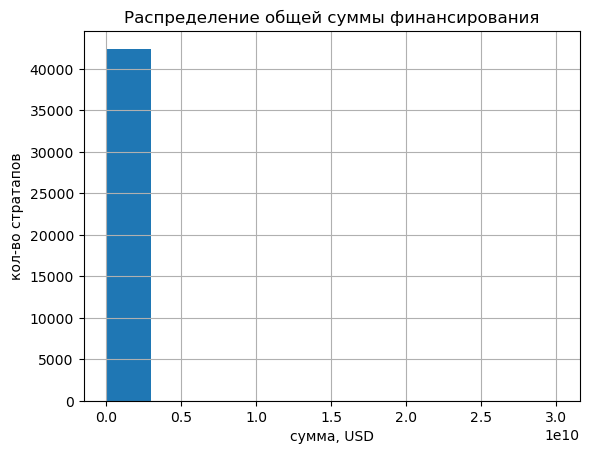

In [84]:
#гистограмма "Общая сумма финансирования в USD" train

train['funding_total_usd'].hist()
plt.title('Распределение общей суммы финансирования')
plt.ylabel('кол-во стратапов')
plt.xlabel('сумма, USD')
plt.show()

<div style="background: #f5f7c4">Явно есть выбросы, посмотрим на долю стратапов, получивших сумму выше средней.</div>

In [85]:
print(f'Доля стартапов, получивших сумму финансирования выше средней: \
{round((train.query('funding_total_usd > 1.824748e+07'))['name'].count()/(train['name'].count())*100)}%')

Доля стартапов, получивших сумму финансирования выше средней: 14%


In [86]:
print(f'Доля стартапов, получивших сумму финансирования менее 100.000: \
{round((train.query('funding_total_usd < 100000'))['name'].count()/(train['name'].count())*100)}%')

Доля стартапов, получивших сумму финансирования менее 100.000: 10%


<div style="background: #f5f7c4">Поскольку есть выбросы как в большую, так и в меньшую сторону, пропуски в сумме финансирования заменим на медиану.</div>

In [87]:
# пайплайн для заполнения пропусков на медиану

simple_imputer_median = Pipeline(
    [
        (
            'SimpleImputer', 
            SimpleImputer(missing_values=np.nan, strategy='median')
        )
    ]
)

In [88]:
# заполнение пропусков с помощью пайплайна

funding = ['funding_total_usd']

train[funding] = simple_imputer_median.fit_transform(train[funding])

In [89]:
#проверка отсутствия пропусков

train.isna().sum()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
closed_at            0
dtype: int64

<div style="background: #bbdb92"><b>Выводы по разделу "Предобработка данных"</b>
<br><br><div style="background: #bbdb92">Предобработка данных завершена. Оба датасета содержат много пропусков. Предобработку данных осуществляли на тренировочном датасете. Тестовый (имитирующий реальный поток данных) датафрейм пока оставляем как есть, данные будут обработаны в ходе подготовки и обучения моделей.
<br><br><div style="background: #bbdb92">Типы данных с датами заменили на datetime.
<br><br><div style="background: #bbdb92">Пропуски в данных о местоположении стратапов заполнили значением "unknown".
<br><br><div style="background: #bbdb92">Пропуски в данных о дате закрытия действующих стртапов заполнили датой выгрузки данных- 2018-01-01.
<br><br><div style="background: #bbdb92">Пропуски в категории стартапа заполнили модой.
<br><br><div style="background: #bbdb92">Пропуски в категории "общая сумма финансирования" заполнили медианой.</div>

## Исследовательский анализ

<div style="background: #f5f7c4">Исследуем количественные признаки train
</div>

In [90]:
train.describe()

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at
count,5.251600e+04,52516.000000,52516.000000,52516.000000,52516.000000
mean,1.513232e+07,1.740670,2008.560096,2011.075691,2012.012491
std,1.683466e+08,1.374522,5.756683,3.613547,3.336599
min,1.000000e+00,1.000000,1970.000000,1977.000000,1977.000000
25%,5.297212e+05,1.000000,2006.000000,2009.000000,2011.000000
50%,2.000000e+06,1.000000,2010.000000,2012.000000,2013.000000
75%,6.788929e+06,2.000000,2013.000000,2014.000000,2014.000000
max,3.007950e+10,19.000000,2016.000000,2015.000000,2015.000000


In [91]:
#заменим тип данных у funding_total_usd

train['funding_total_usd'] = train['funding_total_usd'].astype(int)

<div style="background: #f5f7c4">Максимальная общая сумма финансирования составляет 30 млрд USD, минимальная - 1 USD. Большой разброс значений
<br><br>Количество раундов в среднем 1,7, минимально 1, максимально 19.
<br><br>Дата основания с 1970 по 2016 гг. Дата первого раунда финансирования с 1977 по 2015 гг. дата последнего раунда с 1977 по 2015 гг. Дата закрытия стартапа с 1983 по 2018 гг.
</div>

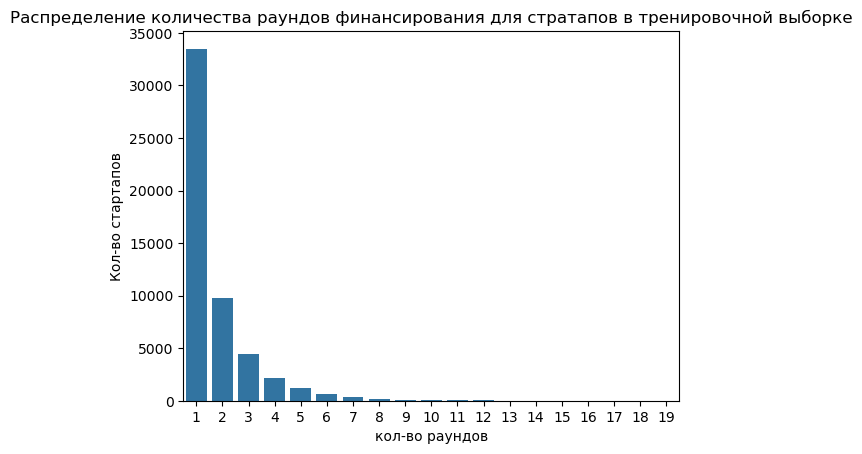

In [92]:
# построим гистограмму для количественного дискретного признака "кол-во раундов финансирования" train

sns.countplot(x = train['funding_rounds'])
plt.title('Распределение количества раундов финансирования для стратапов в тренировочной выборке')
plt.ylabel('Кол-во стартапов')
plt.xlabel('кол-во раундов')
plt.show()

<div style="background: #f5f7c4">Большинство стартапов имеют всего лишь 1 раунд финансирования. Количество раундов варьируется от 1 до 19.
</div>

<div style="background: #f5f7c4">Чтобы проанализировать количественный непрерывный признак "общая сумма финансирования" целесообразно сгруппировать стартапы, поскольку разброс большой и имеются выбросы.
    
- Категория А : более 100 млн
- Категория В : от 50 млн до 100 млн
- Категория С : от 1 до 50 млн
- Категория D : от 500 тыс до 1 млн
- Категория E : до 500 тыс.
</div>

In [93]:
def funding_total_cat(funding_total_usd):
    if funding_total_usd >= 100000000:
         return 'A'
    if 50000000 <= funding_total_usd < 100000000:
         return 'B'
    if 1000000 <= funding_total_usd < 50000000:
         return 'C'
    if 500000 <= funding_total_usd < 1000000:
         return 'D'
    if funding_total_usd < 500000:
         return 'E'
        
train['funding_total_category'] = train['funding_total_usd'].apply(funding_total_cat)

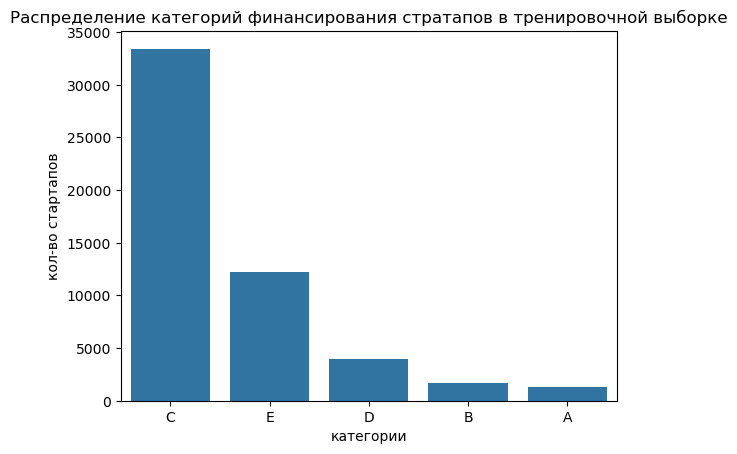

In [94]:
# построим гистограмму для нового признака "funding_total_category" 

sns.countplot(x = train['funding_total_category'], order = train['funding_total_category'].value_counts().index)
plt.title('Распределение категорий финансирования стратапов в тренировочной выборке')
plt.ylabel('кол-во стартапов')
plt.xlabel('категории')
plt.show()

<div style="background: #f5f7c4">Более 30тыс стартапов получили сумму от 1 до 50 млн руб. Далее почти 14тыс получили до 500тыс, 
почти 5тыс от 500тыс до 1 млн и менее всего представлены стартапы с финансированием свыше 50млн.
</div>

<div style="background: #f5f7c4">На основании года открытия и закрытия стартапа добавим новый столбец, который будет отображать кол-во лет существования стартапа.
</div>

In [95]:
train['closed_at'] = train['closed_at'].astype(int)
train['lifetime'] = (train['closed_at'] - train['founded_at'])
train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_total_category,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626,operating,CHE,25,Zurich,Zürich,2,2009,2011,2014,2018,D,9
1,EarLens,Manufacturing|Medical|Medical Devices,42935019,operating,USA,CA,SF Bay Area,Redwood City,4,2005,2010,2014,2018,C,13
2,Reviva Pharmaceuticals,Biotechnology,35456381,operating,USA,CA,SF Bay Area,San Jose,3,2006,2012,2014,2018,C,12
3,Sancilio and Company,Health Care,22250000,operating,unknown,unknown,unknown,unknown,3,2004,2011,2014,2018,C,14
4,WireTough Cylinders,Manufacturing,2000000,operating,USA,VA,VA - Other,Bristol,1,2010,2012,2012,2018,C,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,2000000,operating,CAN,ON,Toronto,Kitchener,1,2012,2014,2014,2018,C,6
52512,Hello Curry,Hospitality,500000,operating,IND,2,Hyderabad,Hyderabad,1,2013,2014,2014,2018,D,5
52513,Taskforce,Email|Messaging|Productivity Software,50000,operating,USA,CA,SF Bay Area,San Francisco,3,2010,2009,2011,2018,E,8
52514,NetScaler,Security,13000000,operating,USA,CA,SF Bay Area,San Jose,6,1997,1998,2004,2018,C,21


In [96]:
train['lifetime'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

<div style="background: #f5f7c4">Поделим кол-во лет на периоды с шагом 10 лет.
</div>

In [97]:
def period_cat(period):
    if 1 <= period <= 10:
         return '1-10'
    if 11 <= period <= 20:
         return '11-20'
    if 21 <= period <= 30:
         return '21-30'
    if 31 <= period <= 40:
         return '31-40'
    if 41 <= period <= 50:
         return '41-50'
        
train['lifetime_category'] = train['lifetime'].apply(period_cat)

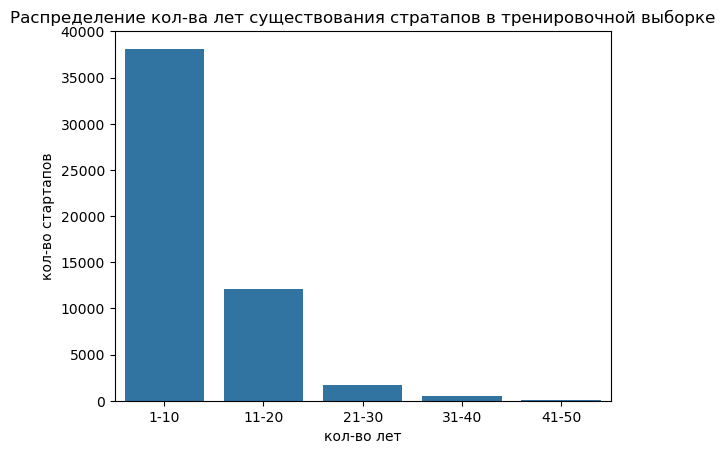

In [98]:
# построим гистограмму для нового признака "lifetime_category" 

sns.countplot(x = train['lifetime_category'], order = train['lifetime_category'].value_counts().index)
plt.title('Распределение кол-ва лет существования стратапов в тренировочной выборке')
plt.ylabel('кол-во стартапов')
plt.xlabel('кол-во лет')
plt.show()

<div style="background: #f5f7c4">Большая часть, почти 40тыс стартапов просуществовали менее 10 лет.
</div>

<div style="background: #f5f7c4">Исследуем категориальные признаки.
</div>

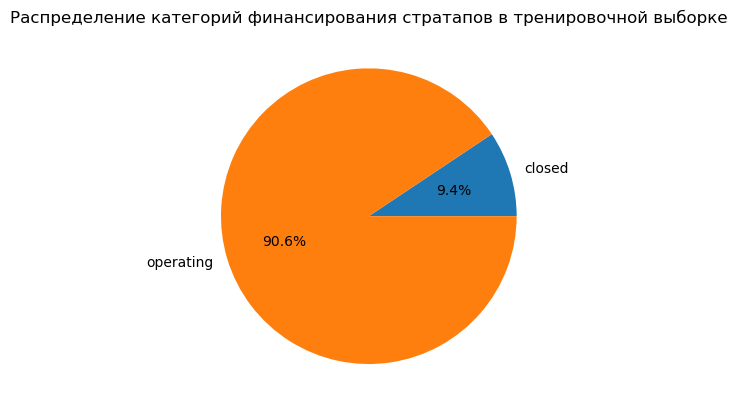

In [99]:
#построим диаграмму для целевого категориального признака status

train.groupby(['status'])['name'].count().plot(kind='pie', autopct='%1.1f%%')
plt.title('Распределение категорий финансирования стратапов в тренировочной выборке')
plt.axis('off')
plt.show()

<div style="background: #f5f7c4">90% стартапов в статусе "действуйющий". Налицо дисбаланс классов, оценивать качество моделей будем метрикой F1-Score.
</div>

In [100]:
train['category_list'].nunique()

22105

In [101]:
train = train.sort_values(by='category_list')
train['category_list'].nunique()

22105

<div style="background: #f5f7c4">Признак "категория стартапа" сожержит 22тыс уникальных значений, попробуем снизить это количество, добавив новый столбец с этим признаком, содержащий только первое значение категории в тех случаях, где их указано несколько. Будем считать, что первая категория - основная категория.
</div>

In [102]:
#создадим новый столбик, взяв первое значение и проверим результат, выведя несколько случайных строк

train['main_category'] = train['category_list'].str.split("|").str[0]
train.sample(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_total_category,lifetime,lifetime_category,main_category
9380,rent2cash.com,Application Platforms|Online Rental|Web Hosting,40000,closed,unknown,unknown,unknown,unknown,1,2013,2014,2014,2015,E,2,1-10,Application Platforms
32837,ZO Rooms,Hospitality|Hotels,47000000,operating,IND,7,New Delhi,New Delhi,2,2014,2015,2015,2018,C,4,1-10,Hospitality
30684,FDM Digital Solutions,Design,1303116,operating,GBR,H2,Burnley,Burnley,1,2013,2014,2014,2018,C,5,1-10,Design
7491,Boost Academy,Internet|Online Education|Tutoring,1575000,operating,unknown,unknown,unknown,unknown,3,2012,2012,2015,2018,C,6,1-10,Internet
25273,BuyFresco,Organic Food,174083,operating,ESP,29,Madrid,Madrid,1,2011,2015,2015,2018,E,7,1-10,Organic Food
6401,Velostrata,Computers|Data Centers|Virtualization,14000000,operating,USA,CA,SF Bay Area,San Jose,3,2014,2014,2015,2018,C,4,1-10,Computers
40083,Proviation,Public Transportation,200000,operating,GBR,A5,GBR - Other,Dunstable,1,2008,2013,2013,2018,E,10,1-10,Public Transportation
13289,doggyloot,Coupons|Discounts|Pets|Social Commerce,2500000,operating,USA,IL,Chicago,Chicago,2,2010,2011,2013,2018,C,8,1-10,Coupons
31144,Parature,Customer Service|Customer Support Tools|Software,30234350,operating,USA,VA,"Washington, D.C.",Herndon,3,2000,2006,2010,2018,C,18,11-20,Customer Service
6447,Discrete Sport,Sports,15000,operating,USA,UT,Salt Lake City,Salt Lake City,1,2008,2011,2011,2018,E,10,1-10,Sports


In [103]:
# снова посмотрим на кол-во уникальных значений

train['main_category'].nunique()

707

<div style="background: #f5f7c4">Уникальных значений стало гораздо меньше, что облегчит дальнейшую работу.
</div>

In [104]:
#посмотрим на кол-во стратапов по категориям, которых в каждой категории не менее 1000

count_category = train['main_category'].value_counts().loc[lambda x : x > 1000]
count_category

main_category
Software               5787
Biotechnology          3592
E-Commerce             2173
Advertising            1926
Curated Web            1747
Mobile                 1396
Analytics              1314
Apps                   1184
Health Care            1134
Enterprise Software    1110
Clean Technology       1106
Games                  1014
Name: count, dtype: int64

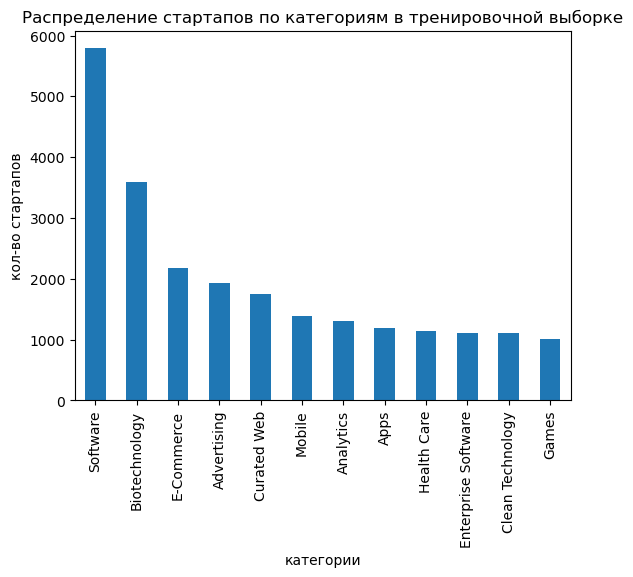

In [105]:
# визуализируем данные

count_category.plot(kind='bar')
plt.title('Распределение стартапов по категориям в тренировочной выборке')
plt.ylabel('кол-во стартапов')
plt.xlabel('категории')
plt.show()

<div style="background: #f5f7c4">Теперь можно сказать, что самые популярные категории стартапов - Разработка ПО и биотехнологии.
</div>

In [106]:
#посмотрим на кол-во стратапов по странам, которых в каждой стране не менее 1000

count_country = train['country_code'].value_counts().loc[lambda x : x > 1000]
count_country

country_code
USA        29702
unknown     5502
GBR         2925
CAN         1540
IND         1276
CHN         1240
Name: count, dtype: int64

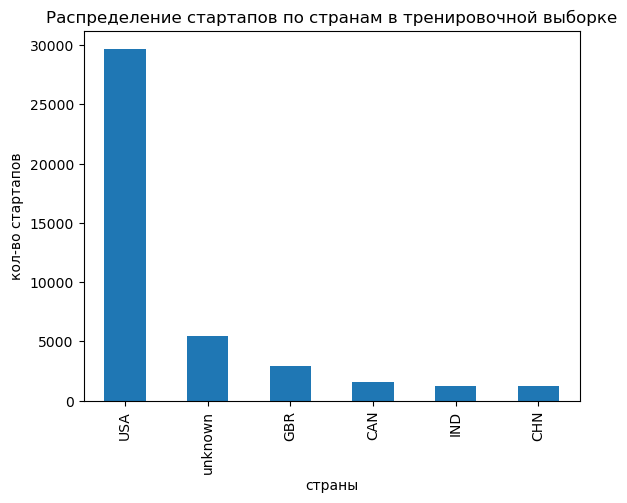

In [107]:
# визуализируем данные

count_country.plot(kind='bar')
plt.title('Распределение стартапов по странам в тренировочной выборке')
plt.ylabel('кол-во стартапов')
plt.xlabel('страны')
plt.show()

<div style="background: #f5f7c4">Больше всего стартапов в США.
</div>

In [108]:
#посмотрим на кол-во стратапов по регионам США, которых в каждом регионе не менее 500

count_region = train['region'].loc[train['country_code'] == 'USA'].value_counts().loc[lambda x : x > 500]
count_region

region
SF Bay Area         6970
New York City       2775
Boston              1890
Los Angeles         1513
Seattle              955
Washington, D.C.     817
Chicago              778
San Diego            703
Austin               652
Denver               638
Atlanta              538
Name: count, dtype: int64

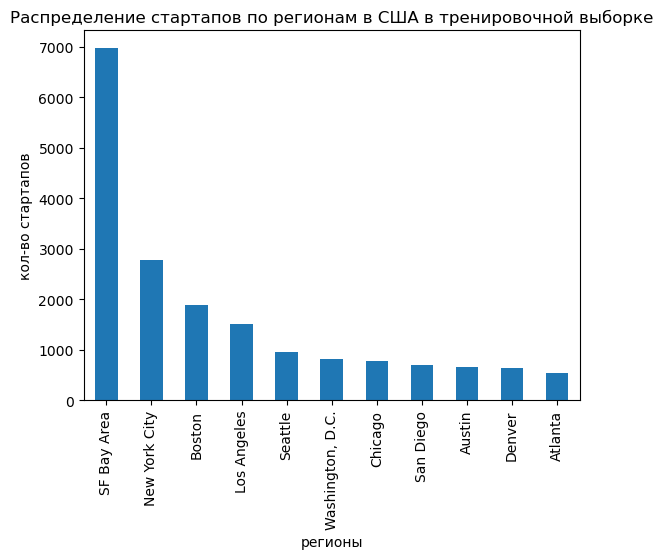

In [109]:
# визуализируем данные

count_region.plot(kind='bar')
plt.title('Распределение стартапов по регионам в США в тренировочной выборке')
plt.ylabel('кол-во стартапов')
plt.xlabel('регионы')
plt.show()

<div style="background: #f5f7c4">Больше всего стартапов США представлено в регионах: Сан-Франциско, Нью-Йорк, Бостон, Лос-Анджелес, т.е. в крупных городах.
</div>

<div style="background: #bbdb92"><b>Выводы по разделу "Исследовательский анализ"</b>
<br><br><div style="background: #bbdb92">На данном этапе обнаружили дисбаланс классов целевого признака (90% в статусе "действующий").</div>
<br><div style="background: #bbdb92">Создали новые признаки:
    
- категория финансирования (5 категорий)
- период существования стартапа (кол-во лет)
- главная категория стартапа

<br>Общая картина тренировочной выборки:

- более 30тыс стартапов получили сумму от 1 до 50 млн руб., около 14тыс получили до 500тыс, почти 5тыс от 500тыс до 1 млн, меньше всего стартапов с суммой выше 50млн.
- большая часть стартапов просуществовала менее 10 лет
- самые популярные категории стартапов - разработка ПО и биотехнологии
- территориально большая часть стартапов находится в США в регионах: Сан-Франциско, Нью-Йорк, Бостон, Лос-Анджелес</div>

## Проверка на мультиколлинеарность

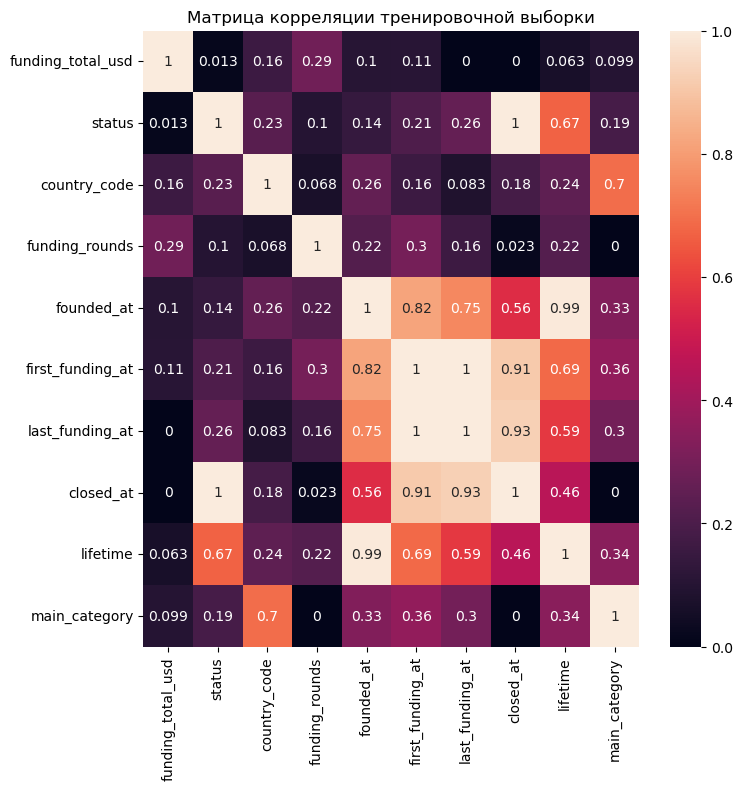

In [62]:
# построим матрицу корреляции для проверки данных на мультиколлинеарность, исключив признаки, содержащие множество уникальных значений
# и новые признаки категорий

plt.figure(figsize=(8, 8))
sns.heatmap(train.drop(['name', 'category_list', 'state_code', 'region', 'city', 'funding_total_category', 'lifetime_category'],
                       axis=1).phik_matrix(interval_cols=['funding_total_usd', 'lifetime']), annot=True)
plt.xticks(rotation=90)
plt.title('Матрица корреляции тренировочной выборки')
plt.show()

<div style="background: #bbdb92">Целевой признак статус высоко коррелирует с признаком длительность существования стартапа (0.86) и практически не коррелирует с суммой финансирования и количеством раундов. Есть небольшая связь с кодом страны, датами первого и последнего раунда финасирования и главной категорией.
Высокая корреляция имеется между главной категорией и кодом страны (0.7), датой основания и первым раундом финасирования (0.82), датой основания и последним раундом финансирования (0.75), датой основания и датой закрытия (0.56).
Также высокая корреляции нового признака длительность с первым и последним раундом финансировани (0.77 и 0.69) и датой закрытия (0.56).
Единички вне основной горизонтальной линии графика указывают на мультиколлинеарность признаков, уберем эти признаки при обучении модели.
</div>

## Подготовка признаков и обучение моделей

In [110]:
train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_total_category,lifetime,lifetime_category,main_category
40186,8i,3D,14481680,operating,unknown,unknown,unknown,unknown,2,2014,2014,2015,2018,C,4,1-10,3D
32252,Visual Realm,3D,2000000,operating,USA,FL,Tampa,Tampa,1,2002,2011,2011,2018,C,16,11-20,3D
13307,Printact,3D Printing,41250,operating,HKG,unknown,Hong Kong,Hong Kong,1,2014,2015,2015,2018,E,4,1-10,3D Printing
33539,Standard Cyborg,3D Printing,120000,operating,USA,CA,SF Bay Area,San Francisco,1,2012,2014,2014,2018,E,6,1-10,3D Printing
27253,Photon Fluid,3D Printing,2000000,closed,USA,CA,SF Bay Area,San Francisco,2,2012,2014,2014,2016,C,4,1-10,3D Printing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23853,Cope it,mHealth,2000000,operating,DNK,17,Copenhagen,Copenhagen,1,2014,2014,2014,2018,C,4,1-10,mHealth
45584,Your.MD,mHealth,7300000,operating,NOR,12,Oslo,Oslo,3,2013,2013,2015,2018,C,5,1-10,mHealth
48083,Skin Analytics,mHealth|Mobile,769131,operating,GBR,C3,London,Cambridge,5,2012,2012,2014,2018,D,6,1-10,mHealth
18684,Umoove,mHealth|Software,2750000,operating,ISR,6,Tel Aviv,Jerusalem,3,2010,2012,2014,2018,C,8,1-10,mHealth


In [112]:
#разбиваем данные на тренировочную и тестовую выборки, стратифицируем выборку

X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['name', 'main_category', 'status', 'state_code', 'region', 'city', 'funding_total_category',
                'lifetime_category', 'closed_at', 'founded_at', 'last_funding_at'], axis=1
    ),
    train['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = train['status']
)

In [113]:
X_train

,category_list,funding_total_usd,country_code,funding_rounds,first_funding_at,lifetime
50617,Health Care,14155000,USA,3,2011,8
12622,Enterprise Software,25482000,unknown,3,2008,11
45531,Banking|Credit Cards|Developer APIs|Finance|Fi...,778660,DEU,3,2012,6
2252,Software,2000000,DEU,2,2010,9
15876,E-Commerce,2000000,USA,1,2013,6
...,...,...,...,...,...,...
20959,E-Commerce|Software,100000,GHA,1,2010,8
52247,Education,2500000,USA,1,2015,5
14961,Enterprise Software,1400000,USA,2,2013,6
33521,Communities|DIY|Home & Garden|Internet|Lifesty...,564400,ITA,2,2011,7


In [114]:
#закодируем целевой признак

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
pred_classes = [0, 1]
print(label_encoder.inverse_transform(pred_classes))

['closed' 'operating']


In [115]:
#создаём списки с названиями признаков

ohe_columns = ['country_code', 'category_list']

num_columns = ['funding_total_usd', 'lifetime', 'funding_rounds', 'first_funding_at']


In [116]:
#cоздаём пайплайн для подготовки признаков из списка ohe_columns:

ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
 )
print(ohe_pipe)

Pipeline(steps=[('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])


In [117]:
#создаём общий пайплайн для подготовки данных

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder = 'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['country_code', 'category_list']),
                                ('num', MinMaxScaler(),
                                 ['funding_total_usd', 'lifetime',
                                  'funding_rounds', 'first_funding_at'])])


In [118]:
# создаём итоговый пайплайн: подготовка данных и модель

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])
print(pipe_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'category_list']),
                                                 ('num', MinMaxScaler(),
                                                  ['funding_total_usd',
                                                   'lifetime', 'funding_rounds',
                                                   'first_funding_at'])])),
                ('models', Dec

In [119]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth' : range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
   
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors' : range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [120]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE
)

In [121]:
random_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика F1-score лучшей модели на кросс-валидационной выборке:', random_search.best_score_)

  File "D:\programs\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'category_list']),
                                                 ('num', MinMaxScaler(),
                                                  ['funding_total_usd',
                                                   'lifetime', 'funding_rounds',
                                                   'first_funding_at'])]))

In [122]:
y_test_pred = random_search.predict(X_test)
print(f'Метрика F1-score на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Метрика F1-score на тестовой выборке: 0.9844546698171869


<div style="background: #f5f7c4">Лучшая модель - Логистическая регрессия.
<br>Метрика F1 на кросс-валидационной выборке = 0.98.
<br>Метрика F1 на тестовой выборке = 0.98.                                                      
</div>

In [123]:
# создадим и обучим DummyClassifier на тренировочных данных
# выполним предсказание на тестовой выборке
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_test)

# посчитаем метрику 
dummy_roc = f1_score(y_test, dummy_model_preds)
print('Метрика F1-score дамми-модели =', round(dummy_roc,2))

Метрика F1-score дамми-модели = 0.95


<div style="background: #f5f7c4">Метрика F1 дамми-модели ниже, чем метрика на тестовой выборке, значит наша модель адекватна и может быть использована в дальнейшей работе.
</div>

<div style="background: #bbdb92"><b>Выводы по разделу "Подготовка признаков и обучение моделей"</b>
<br><br>На данном этапе выполнили подготовку признаков и обучение моделей с помощью пайплайнов. 
<br><br>Целевой признак "статус" закодировали с помощью LabelEncoder. 
<br><br>Количественный признак "сумма финасирования" масштабировали с помощью MinMaxScaler. 
<br><br>Категориальные признаки закодировали с помощью OneHotEncoder. 
<br><br>Обучили 3 модели: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression.
<br><br>Поскольку пристутствует дисбаланс целевого признака, оценивали модели метрикой F1-score.
<br><br>Лучшей моделью оказалась логистическая регрессия с метрикой на кросс-валидационной и тестовой выборке - 0.98.
<br><br>Проверили адекватность модели с помощью дамми-модели.</div>

## Анализ важности признаков

<div style="background: #f5f7c4">Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP.                                               
</div>

PermutationExplainer explainer: 6it [00:16,  5.54s/it]                                                                 


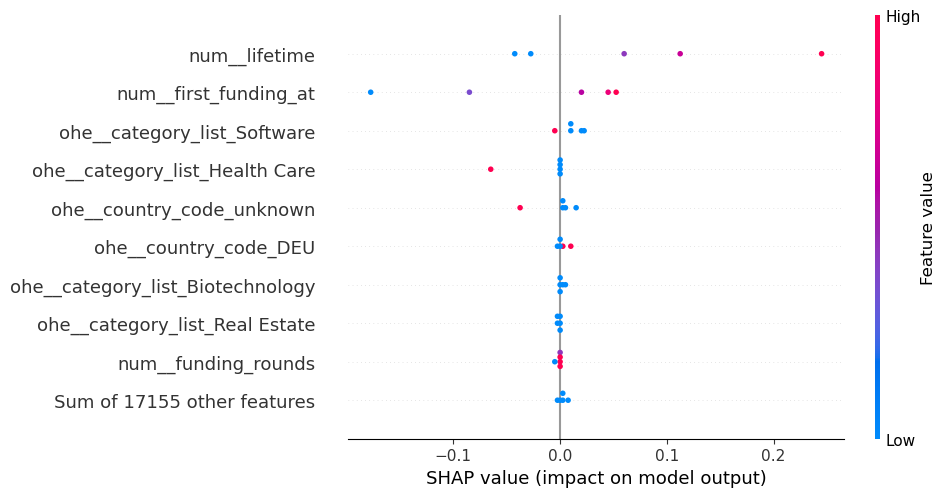

In [124]:
X = random_search.best_estimator_['preprocessor'].fit_transform(X_train)
X = pd.DataFrame(X, columns = random_search.best_estimator_['preprocessor'].get_feature_names_out())
explainer = shap.Explainer(random_search.best_estimator_['models'].predict, X)
shap_values = explainer(X[:5])
shap.plots.beeswarm(shap_values)

<div style="background: #bbdb92"><b>Выводы по разделу "Анализ важности признаков"</b>
<br><br>На данном этапе оценили важность признаков методом SHAP. Диаграмма размаха отражает вклад всех признаков в классификацию каждого наблюдения. Самыми значимыми признаками являются: длительность существования, дата первого раунда финснирования.</div>

## Получение предсказаний

In [125]:
test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [126]:
# заполнение пропусков с помощью пайплайна

test[cols_train_address] = simple_imputer_unknown.fit_transform(test[cols_train_address])

test[category] = simple_imputer_moda.fit_transform(test[category])

test[funding] = simple_imputer_median.fit_transform(test[funding])

In [127]:
test.isna().sum()

name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

In [128]:
#создадим новые столбцы с новыми признаками по аналогии с train

test['main_category'] = test['category_list'].str.split("|").str[0]
#test['funding_total_category'] = test['funding_total_usd'].apply(funding_total_cat)
test['lifetime'] = round(test['lifetime']/365).astype(int)

test.sample(4)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,main_category
3211,Viaziz Scam,Auctions|E-Commerce|Internet,2500.0,unknown,unknown,unknown,unknown,1,2011,2011,1,Auctions
4913,fav.or.it,Blogging Platforms|Curated Web,712000.0,GBR,K7,London,Reading,1,2009,2009,3,Blogging Platforms
10600,Sadbhav Infrastructure Projects,Real Estate,31000000.0,IND,9,Ahmedabad,Ahmedabad,1,2015,2015,30,Real Estate
9906,Grenville Strategic Royalty,Software,15000000.0,unknown,unknown,unknown,unknown,1,2014,2014,5,Software


In [129]:
# Предсказание на валидационной выборке
test['status'] = random_search.best_estimator_.predict(test)

In [130]:
test['status'] = label_encoder.inverse_transform(test['status'])
test['status']

0        operating
1        operating
2        operating
3        operating
4        operating
           ...    
13120    operating
13121    operating
13122    operating
13123    operating
13124    operating
Name: status, Length: 13125, dtype: object

In [131]:
df = test[['name','status']]
df.reset_index(drop=True)
df

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


In [132]:
status = df['status'].value_counts()
status

status
operating    12196
closed         929
Name: count, dtype: int64

In [133]:
df = test[['name','status']].to_csv('startup_preds_1.csv',index = False)

<div style="background: #bbdb92"><b>Выводы по разделу "Получение предсказаний"</b>
<br><br>Подготовили тестовые данные: заполнили пропуски пайплайнами, создали новые признаки.
<br><br>Получили предсказания по лучшей модели. Модель предсказала статус "действующий" для 12.195 стартапов, статус "закрыт" для 930 стартапов.
<br><br>Данные предсказания загружены на платформу Kaggle для проверки, где получены метрика F1-score равная 0.80747.</div>

<div style="background: #bbdb92"><b>Общий вывод по проекту</b>
<br><br>Проект непростой, поскольку данные очень "грязные", много уникальных значений признаков.
<br><br>Получена адекватная модель, которая в целом показывает неплохое значение F1-score. Однако, есть к чему стремиться.
<br><br>Что можно сделать для улучшения метрики:

- более тщательный разведочный анализ
- создание других новых синтетических признаков
- обучение других моделей</div>